# Data Preparation

---

This notebook outlines the process for preparing the Zillow property data needed for this project. This notebook also demonstrates the steps to create and test the functions in the util/prepare.py file.

---

## Importing the Required Modules

Below we import all the modules needed to run this notebook. Note that you will need the univariate_analysis.py file located in the notebooks directory in order to run some of the code blocks in this notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from univariate_analysis import get_hist, get_box

from env import username, password, hostname

---

## Acquire Data

Here we define all our acquisition functions created in the acquire notebook.

In [2]:
def get_db_url(database_name, username = username, password = password, hostname = hostname):
    return f'mysql+pymysql://{username}:{password}@{hostname}/{database_name}'

def get_zillow_sql():
    return """
        SELECT
            bedroomcnt,
            bathroomcnt,
            calculatedfinishedsquarefeet,
            taxvaluedollarcnt,
            yearbuilt,
            fips,
            numberofstories,
            basementsqft,
            fireplacecnt,
            heatingorsystemdesc,
            roomcnt,
            garagetotalsqft,
            hashottuborspa,
            poolcnt,
            poolsizesum,
            yardbuildingsqft17
        FROM properties_2017
        JOIN propertylandusetype
            ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
            AND (propertylandusetype.propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential'))
        LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid);
        """

def get_zillow_data(use_cache = True):
    # If the file is cached, read from the .csv file
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cache')
        return pd.read_csv('zillow.csv')
    
    # Otherwise read from the mysql database
    else:
        print('Reading from database')
        df = pd.read_sql(get_zillow_sql(), get_db_url('zillow'))
        df.to_csv('zillow.csv', index = False)
        return df

In [3]:
# Now we can load our dataset.
properties = get_zillow_data()

Reading from database


---

## Initial Analysis (Looking for Unusual Values and Outliers)

We will start by getting an overview of our data and determining whether or not there exist unusual values or outliers that may affect our results.

In [4]:
properties.shape

(2152864, 17)

In [5]:
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2152853.0,3.287195,0.954757,0.0,3.00,3.0,4.0,25.0
bathroomcnt,2152853.0,2.230687,0.999281,0.0,2.00,2.0,3.0,32.0
calculatedfinishedsquarefeet,2144379.0,1862.855178,1222.125124,1.0,1257.00,1623.0,2208.0,952576.0
taxvaluedollarcnt,2152371.0,461896.052361,699675.940049,1.0,188170.00,327671.0,534527.0,98428909.0
yearbuilt,2143526.0,1960.949681,22.162196,1801.0,1949.00,1958.0,1976.0,2016.0
fips,2152864.0,6048.377330,20.433289,6037.0,6037.00,6037.0,6059.0,6111.0
numberofstories,590839.0,1.386009,0.537773,1.0,1.00,1.0,2.0,41.0
basementsqft,1538.0,651.190507,552.078809,20.0,261.75,519.5,889.5,8516.0
fireplacecnt,287596.0,1.178726,0.474376,1.0,1.00,1.0,1.0,9.0
roomcnt,2152847.0,1.864986,3.122051,0.0,0.00,0.0,5.0,96.0


**Takeaways**
- bedroomcnt and bathroomcnt both have minimum values of 0 which might make sense for a studio apartment, but it does seem unusual.
- calculatedfinishedsquarefeet has a minimum value of 1 which doesn't seem right.
- roomcnt has a minimum value of 0 which is unusual.

Now let's look at histograms and boxplots of our features to determine if there are any outliers.

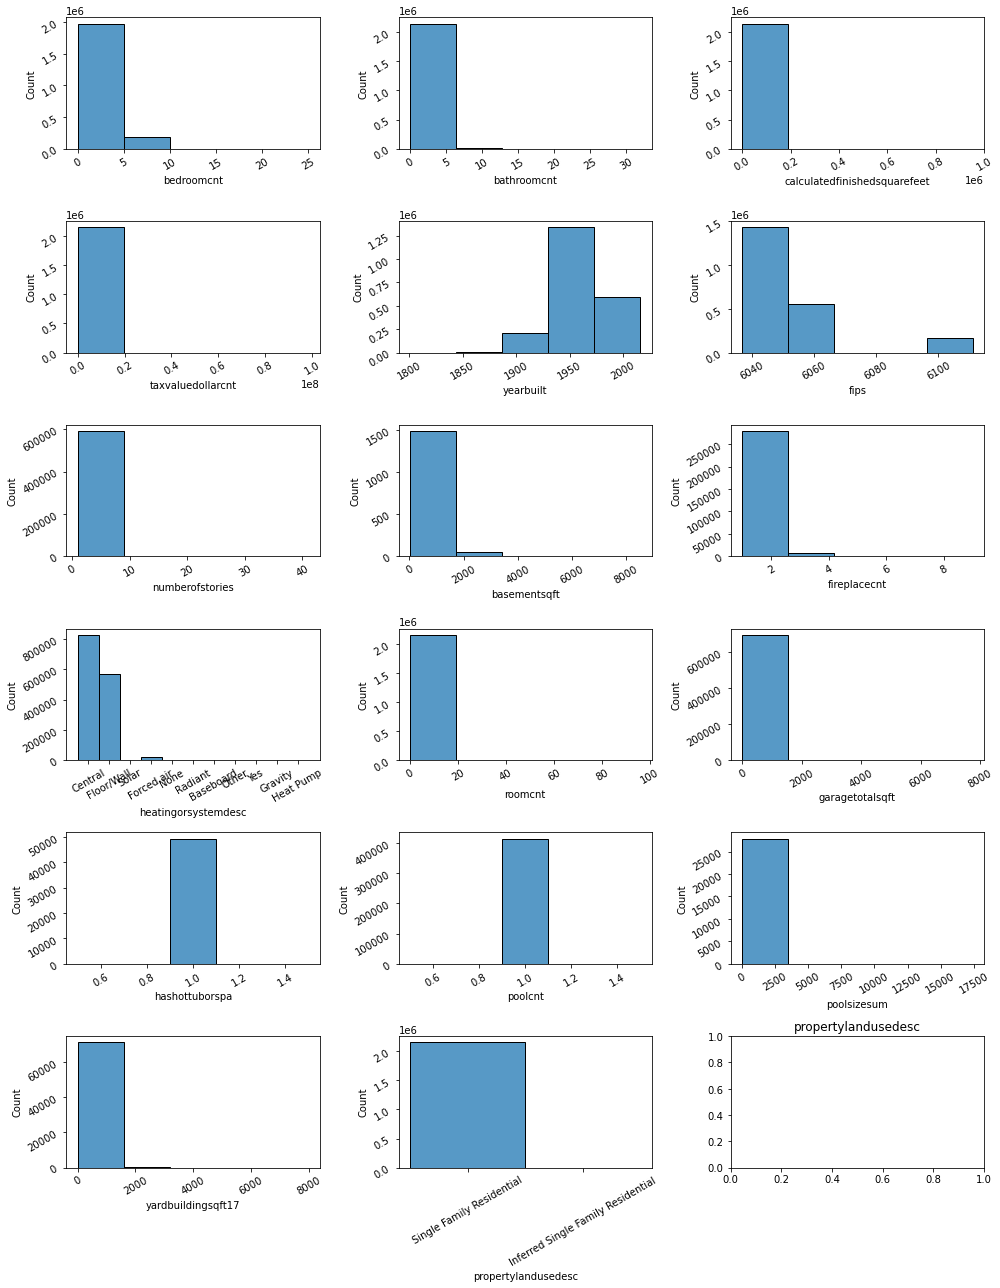

In [6]:
get_hist(properties, properties.columns)

All the following columns possibly have outliers:
- bedroomcnt
- bathroomcnt
- calculatedfinishedsquarefeet
- numberofstories
- basementsqft
- fireplacecnt
- roomcnt
- garagetotalsqft
- poolsizesum
- yardbuildingsqft17

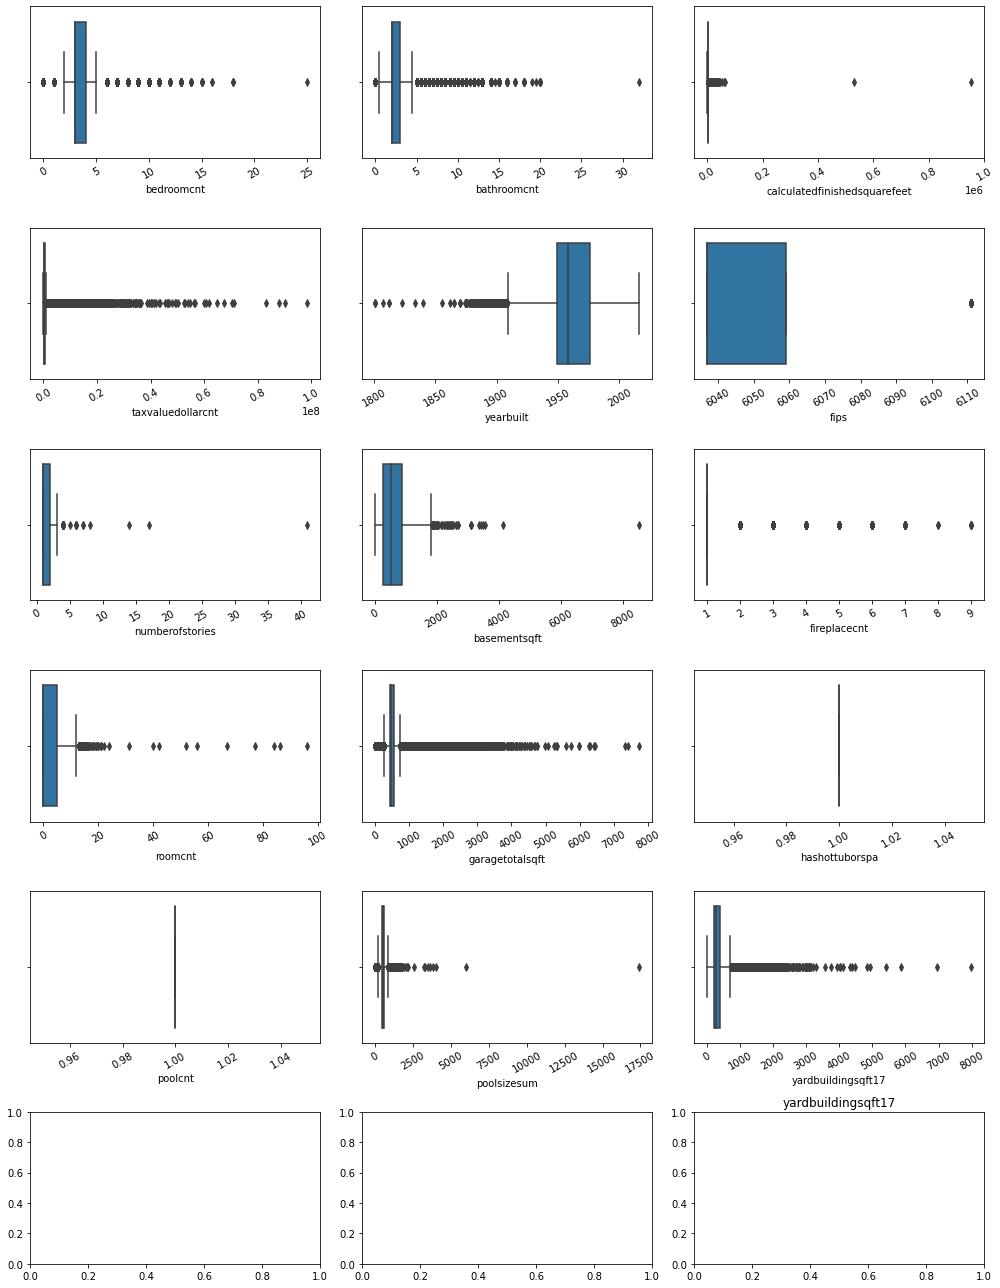

In [7]:
get_box(properties, properties.select_dtypes('number').columns)

Outliers here match previously identified, plus yearbuilt has outliers.

The columns with the most pronounced outliers are:
- calculatedfinishedsquarefeet
- bedroomcnt
- bathroomcnt
- garagetotalsqft

taxvaluedollarcnt also has a large number of outliers, but since this is our target variable we'll leave it alone.

Now we will remove outliers from the dataset.

In [21]:
# Remove outliers

def remove_outliers(df, k, col_list):    
    for col in col_list:
        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

# Must remove outliers only from columns where the values don't make sense otherwise we
# lose almost all our data.

columns = [
    'calculatedfinishedsquarefeet',
    'bedroomcnt',
    'bathroomcnt',
    'garagetotalsqft'
]

properties = remove_outliers(properties, 1.5, columns)

With outliers removed let's now take a look at our data again to see if the unusual values were also removed.

In [22]:
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,502774.0,3.461382,0.693676,2.0,3.0,3.0,4.0,5.0
bathroomcnt,502774.0,2.286806,0.426491,1.5,2.0,2.0,2.5,3.0
calculatedfinishedsquarefeet,502774.0,1826.594098,511.992113,169.0,1426.0,1736.0,2147.0,3634.0
taxvaluedollarcnt,502762.0,406814.372170,276762.674397,10000.0,232946.0,368737.0,536000.0,17575461.0
yearbuilt,502390.0,1971.804371,14.857753,1880.0,1961.0,1969.0,1980.0,2016.0
fips,502774.0,6070.471619,21.562168,6059.0,6059.0,6059.0,6059.0,6111.0
numberofstories,429583.0,1.350910,0.523823,1.0,1.0,1.0,2.0,41.0
basementsqft,505.0,564.275248,376.789052,20.0,252.0,493.0,794.0,1889.0
fireplacecnt,213730.0,1.092018,0.314643,1.0,1.0,1.0,1.0,7.0
roomcnt,502774.0,5.795892,2.600429,0.0,6.0,6.0,7.0,86.0


Removing the outliers got rid of most of the unusual values, but it also removed a large portion of the dataset. We'll continue to investigate the unusual values later. As for the large amount of removed rows, for now we will continue forward as is. If time permits we'll come back to run the pipeline again with outliers intact.

---

## Missing Values

Now let's investigate any missing values in our dataset.

In [24]:
# This shows us the total number of rows.
properties.shape

(502774, 17)

In [23]:
# Now let's see the total non-null counts for each column.
properties.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502774 entries, 23 to 2152862
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   bedroomcnt                    502774 non-null  float64
 1   bathroomcnt                   502774 non-null  float64
 2   calculatedfinishedsquarefeet  502774 non-null  float64
 3   taxvaluedollarcnt             502762 non-null  float64
 4   yearbuilt                     502390 non-null  float64
 5   fips                          502774 non-null  float64
 6   numberofstories               429583 non-null  float64
 7   basementsqft                  505 non-null     float64
 8   fireplacecnt                  213730 non-null  float64
 9   heatingorsystemdesc           17477 non-null   object 
 10  roomcnt                       502774 non-null  float64
 11  garagetotalsqft               502774 non-null  float64
 12  hashottuborspa                23396 non-nu

We can see that several columns have missing values:
- taxvaluedollarcnt
- yearbuilt
- numberofstories
- basementsqft
- fireplacecnt
- heatingorsystemdesc
- hashottuborspa
- poolcnt
- poolsizesum
- yardbuildingsqft17

We'll investigate each column and determine the best course of action accordingly.

### taxvaluedollarcnt

There are a few missing values in the target variable. Since this is our target and it is just missing a small number of values we'll just remove those rows from the data.

In [32]:
# Remove all rows missing the taxvaluedollarcnt value.
missing_target = properties.taxvaluedollarcnt.isnull()
properties = properties[~missing_target]

In [33]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                           0
bathroomcnt                          0
calculatedfinishedsquarefeet         0
taxvaluedollarcnt                    0
yearbuilt                          384
fips                                 0
numberofstories                  73187
basementsqft                    502257
fireplacecnt                    289039
heatingorsystemdesc             485285
roomcnt                              0
garagetotalsqft                      0
hashottuborspa                  479367
poolcnt                         412535
poolsizesum                     487337
yardbuildingsqft17              453436
propertylandusedesc                  0
dtype: int64

### yearbuilt

The yearbuilt column is also only missing a few values. For this column we will fill in the missing values with the mode for the yearbuilt column.

In [34]:
properties.yearbuilt.mode()[0]

1964.0

In [35]:
# Fill each null value in yearbuilt with the mode (1964)
properties.yearbuilt.fillna(properties.yearbuilt.mode()[0], inplace = True)

# Let's also cast the column to int since year does not need to be a floating point value.
properties.yearbuilt = properties.yearbuilt.astype('int')

In [37]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                           0
bathroomcnt                          0
calculatedfinishedsquarefeet         0
taxvaluedollarcnt                    0
yearbuilt                            0
fips                                 0
numberofstories                  73187
basementsqft                    502257
fireplacecnt                    289039
heatingorsystemdesc             485285
roomcnt                              0
garagetotalsqft                      0
hashottuborspa                  479367
poolcnt                         412535
poolsizesum                     487337
yardbuildingsqft17              453436
propertylandusedesc                  0
dtype: int64

### numberofstories

There are a lot of missing values in the numberofstories column. Let's take a look at the unique values to see if there is a value that can reasonably replace the nulls.

In [39]:
properties.numberofstories.value_counts()

1.0     287873
2.0     132751
3.0       8936
4.0          6
6.0          3
7.0          2
41.0         1
14.0         1
17.0         1
8.0          1
Name: numberofstories, dtype: int64

We can't assume the nulls represent 0 stories because this wouldn't make sense. There are values already for 1 story so we can't assume the nulls represent 1 story. Since there are a lot of missing values here we are probably better off removing this column.

In [40]:
properties = properties.drop(columns = 'numberofstories')

In [41]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                           0
bathroomcnt                          0
calculatedfinishedsquarefeet         0
taxvaluedollarcnt                    0
yearbuilt                            0
fips                                 0
basementsqft                    502257
fireplacecnt                    289039
heatingorsystemdesc             485285
roomcnt                              0
garagetotalsqft                      0
hashottuborspa                  479367
poolcnt                         412535
poolsizesum                     487337
yardbuildingsqft17              453436
propertylandusedesc                  0
dtype: int64

### basementsqft

The basementsqft column has a huge number of missing values. Let's take a look at what values exist in this column.

In [44]:
properties.basementsqft.value_counts().sort_index()

20.0      1
25.0      1
30.0      1
36.0      1
55.0      1
         ..
1636.0    1
1671.0    2
1680.0    1
1689.0    1
1889.0    1
Name: basementsqft, Length: 338, dtype: int64

Since the lowest value is 20 square feet it's reasonable to assume that a null value represents no basement on the property. With this in mind we can reasonably assume that the nulls are 0 square feet so we will fill in those missing values with 0.

In [45]:
properties.basementsqft.fillna(0, inplace = True)

In [46]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                           0
bathroomcnt                          0
calculatedfinishedsquarefeet         0
taxvaluedollarcnt                    0
yearbuilt                            0
fips                                 0
basementsqft                         0
fireplacecnt                    289039
heatingorsystemdesc             485285
roomcnt                              0
garagetotalsqft                      0
hashottuborspa                  479367
poolcnt                         412535
poolsizesum                     487337
yardbuildingsqft17              453436
propertylandusedesc                  0
dtype: int64

### fireplacecnt

The fireplacecnt column has a huge number of missing values. Let's take a look at what values exist in this column.

In [47]:
properties.fireplacecnt.value_counts()

1.0    195645
2.0     16538
3.0      1499
4.0        37
6.0         2
5.0         1
7.0         1
Name: fireplacecnt, dtype: int64

Again since there is no 0 value we can reasonably assume that a null is no fireplace. We'll fill in the nulls with 0.

In [48]:
properties.fireplacecnt.fillna(0, inplace = True)

# Let's also cast this column to the int type since a fractional fireplace is not possible.
properties.fireplacecnt = properties.fireplacecnt.astype('int')

In [49]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                           0
bathroomcnt                          0
calculatedfinishedsquarefeet         0
taxvaluedollarcnt                    0
yearbuilt                            0
fips                                 0
basementsqft                         0
fireplacecnt                         0
heatingorsystemdesc             485285
roomcnt                              0
garagetotalsqft                      0
hashottuborspa                  479367
poolcnt                         412535
poolsizesum                     487337
yardbuildingsqft17              453436
propertylandusedesc                  0
dtype: int64

### heatingorsystemdesc

The heatingorsystemdesc column has a huge number of missing values. Let's take a look at what values exist in this column.

In [50]:
properties.heatingorsystemdesc.value_counts()

Forced air    16159
Floor/Wall      785
None            357
Baseboard        70
Radiant          54
Other            35
Gravity          12
Heat Pump         3
Yes               2
Name: heatingorsystemdesc, dtype: int64

Here we do have values to represent no heating system. We can't make any reasonable assumption about what the nulls might be. There are too many missing values to fill with something like mode so we are better off dropping this column.

In [51]:
properties = properties.drop(columns = 'heatingorsystemdesc')

In [52]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                           0
bathroomcnt                          0
calculatedfinishedsquarefeet         0
taxvaluedollarcnt                    0
yearbuilt                            0
fips                                 0
basementsqft                         0
fireplacecnt                         0
roomcnt                              0
garagetotalsqft                      0
hashottuborspa                  479367
poolcnt                         412535
poolsizesum                     487337
yardbuildingsqft17              453436
propertylandusedesc                  0
dtype: int64

### hashottuborspa

The hashottuborspa column has a huge number of missing values. Let's take a look at what values exist in this column.

In [53]:
properties.hashottuborspa.value_counts()

1.0    23395
Name: hashottuborspa, dtype: int64

Here there is only a value to represent that the property has 1 hot tub. We can reasonably assume the nulls represent no hot tub or spa. We'll fill the null values with 0.

In [54]:
properties.hashottuborspa.fillna(0, inplace = True)
properties.hashottuborspa = properties.hashottuborspa.astype('int')

In [55]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                           0
bathroomcnt                          0
calculatedfinishedsquarefeet         0
taxvaluedollarcnt                    0
yearbuilt                            0
fips                                 0
basementsqft                         0
fireplacecnt                         0
roomcnt                              0
garagetotalsqft                      0
hashottuborspa                       0
poolcnt                         412535
poolsizesum                     487337
yardbuildingsqft17              453436
propertylandusedesc                  0
dtype: int64

### poolcnt and poolsizesum

The poolcnt and poolsizesum columns both have a huge amount of missing values. Let's take a look at what values exist in these columns.

In [56]:
properties.poolcnt.value_counts()

1.0    90227
Name: poolcnt, dtype: int64

In [57]:
properties.poolsizesum.value_counts().sort_index()

19.0       1
20.0       2
24.0       1
28.0       8
35.0       1
          ..
1920.0     1
3510.0     1
4000.0     1
6000.0     1
17410.0    1
Name: poolsizesum, Length: 678, dtype: int64

These features do not have the same number of missing values. We have more information for poolcnt, but poolsizesum could be more valuable for assessing property value. We can't have a property with a pool and 0 pool size so we will need to drop one of these columns. The other can reasonably be filled in with 0.

Since poolsizesum has more missing values we'll drop that one and keep poolcnt. We'll fill the null values in poolcnt with 0.

In [58]:
properties = properties.drop(columns = 'poolsizesum')
properties.poolcnt.fillna(0, inplace = True)

# Let's also cast poolcnt to an int type since a fractional pool is not possible.
properties.poolcnt = properties.poolcnt.astype('int')

In [59]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                           0
bathroomcnt                          0
calculatedfinishedsquarefeet         0
taxvaluedollarcnt                    0
yearbuilt                            0
fips                                 0
basementsqft                         0
fireplacecnt                         0
roomcnt                              0
garagetotalsqft                      0
hashottuborspa                       0
poolcnt                              0
yardbuildingsqft17              453436
propertylandusedesc                  0
dtype: int64

### yardbuildingsqft17

Finally the yardbuildingsqft17 column has a large number of missing values. Let's take a look at what values exist in this column.

In [60]:
properties.yardbuildingsqft17.value_counts().sort_index()

10.0      1
11.0      1
12.0      2
13.0      2
14.0      2
         ..
2962.0    1
3080.0    1
4480.0    1
5400.0    1
5880.0    1
Name: yardbuildingsqft17, Length: 1284, dtype: int64

We may be able to assume null is no patio, but there are a large number of missing values here and most residential homes are likely going to have at least a small patio. We may be better off dropping this column since it's difficult to assume what the nulls may represent.

In [61]:
properties = properties.drop(columns = 'yardbuildingsqft17')

In [62]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
fips                            0
basementsqft                    0
fireplacecnt                    0
roomcnt                         0
garagetotalsqft                 0
hashottuborspa                  0
poolcnt                         0
propertylandusedesc             0
dtype: int64

---

## A Second Brief Analysis

Now that we are done handling all the missing values let's take a look at our data one more time before wrapping this up.

In [63]:
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,502762.0,3.461395,0.693661,2.0,3.0,3.0,4.0,5.0
bathroomcnt,502762.0,2.286809,0.426492,1.5,2.0,2.0,2.5,3.0
calculatedfinishedsquarefeet,502762.0,1826.597521,511.995909,169.0,1426.0,1736.0,2147.0,3634.0
taxvaluedollarcnt,502762.0,406814.372170,276762.674397,10000.0,232946.0,368737.0,536000.0,17575461.0
yearbuilt,502762.0,1971.798322,14.853698,1880.0,1961.0,1969.0,1980.0,2016.0
fips,502762.0,6070.471273,21.561934,6059.0,6059.0,6059.0,6059.0,6111.0
basementsqft,502762.0,0.566787,21.490071,0.0,0.0,0.0,0.0,1889.0
fireplacecnt,502762.0,0.464216,0.577515,0.0,0.0,0.0,1.0,7.0
roomcnt,502762.0,5.795939,2.600402,0.0,6.0,6.0,7.0,86.0
garagetotalsqft,502762.0,460.813556,60.340477,307.0,424.0,456.0,483.0,622.0


The only issue is that it doesn't make sense for roomcnt to be 0. Let's take a look at what values exist in this column.

In [65]:
properties.roomcnt.value_counts().sort_index()

0.0      72139
1.0         13
2.0        136
3.0        376
4.0       4423
5.0      44363
6.0     137762
7.0     131129
8.0      86226
9.0      23870
10.0      2064
11.0       182
12.0        64
13.0         2
14.0         2
15.0         2
18.0         1
19.0         1
20.0         1
24.0         1
56.0         1
67.0         1
77.0         1
84.0         1
86.0         1
Name: roomcnt, dtype: int64

We don't want to remove 72,000 rows, especially since we have already removed a lot of rows when removing the outliers, so we will drop the column.

In [66]:
properties = properties.drop(columns = 'roomcnt')

In [67]:
# Let's take one more look.
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,502762.0,3.461395,0.693661,2.0,3.0,3.0,4.0,5.0
bathroomcnt,502762.0,2.286809,0.426492,1.5,2.0,2.0,2.5,3.0
calculatedfinishedsquarefeet,502762.0,1826.597521,511.995909,169.0,1426.0,1736.0,2147.0,3634.0
taxvaluedollarcnt,502762.0,406814.372170,276762.674397,10000.0,232946.0,368737.0,536000.0,17575461.0
yearbuilt,502762.0,1971.798322,14.853698,1880.0,1961.0,1969.0,1980.0,2016.0
fips,502762.0,6070.471273,21.561934,6059.0,6059.0,6059.0,6059.0,6111.0
basementsqft,502762.0,0.566787,21.490071,0.0,0.0,0.0,0.0,1889.0
fireplacecnt,502762.0,0.464216,0.577515,0.0,0.0,0.0,1.0,7.0
garagetotalsqft,502762.0,460.813556,60.340477,307.0,424.0,456.0,483.0,622.0
hashottuborspa,502762.0,0.046533,0.210636,0.0,0.0,0.0,0.0,1.0


Now let's see if there are any columns that should be cast to a different type.

In [77]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502762 entries, 23 to 2152862
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   bedroom_count                 502762 non-null  float64
 1   bathroom_count                502762 non-null  float64
 2   square_feet                   502762 non-null  float64
 3   property_tax_assessed_values  502762 non-null  float64
 4   year_built                    502762 non-null  int64  
 5   fed_code                      502762 non-null  float64
 6   basement_square_feet          502762 non-null  float64
 7   fireplace_count               502762 non-null  int64  
 8   garage_square_feet            502762 non-null  float64
 9   has_hot_tub                   502762 non-null  int64  
 10  has_pool                      502762 non-null  int64  
 11  propertylandusedesc           502762 non-null  object 
dtypes: float64(7), int64(4), object(1)
memory 

The columns bedroomcnt, fips, and bathroomcnt should possibly be int types. Let's make sure.

In [78]:
properties.bedroomcnt.value_counts()

3.0    240694
4.0    203583
2.0     29527
5.0     28958
Name: bedroom_count, dtype: int64

In [79]:
properties.fips.value_counts()

6059.0    391852
6111.0    110910
Name: fed_code, dtype: int64

In [80]:
properties.bathroomcnt.value_counts()

2.0    260510
2.5    120835
3.0     96325
1.5     25092
Name: bathroom_count, dtype: int64

We will cast bedroomcnt and fips to int type.

In [81]:
properties.bedroomcnt = properties.bedroomcnt.astype('int')
properties.fips = properties.fips.astype('int')

In [82]:
# Let's make sure it worked.
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502762 entries, 23 to 2152862
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   bedroom_count                 502762 non-null  int64  
 1   bathroom_count                502762 non-null  float64
 2   square_feet                   502762 non-null  float64
 3   property_tax_assessed_values  502762 non-null  float64
 4   year_built                    502762 non-null  int64  
 5   fed_code                      502762 non-null  int64  
 6   basement_square_feet          502762 non-null  float64
 7   fireplace_count               502762 non-null  int64  
 8   garage_square_feet            502762 non-null  float64
 9   has_hot_tub                   502762 non-null  int64  
 10  has_pool                      502762 non-null  int64  
 11  propertylandusedesc           502762 non-null  object 
dtypes: float64(5), int64(6), object(1)
memory 

Everything looks good.

---

## Rename Columns

Finally, let's rename these columns so that they will be more readable.

In [83]:
properties = properties.rename(columns = {
    'bedroomcnt' : 'bedroom_count',
    'bathroomcnt' : 'bathroom_count',
    'calculatedfinishedsquarefeet' : 'square_feet',
    'taxvaluedollarcnt' : 'property_tax_assessed_values',
    'yearbuilt' : 'year_built',
    'fips' : 'fed_code',
    'basementsqft' : 'basement_square_feet',
    'fireplacecnt' : 'fireplace_count',
    'garagetotalsqft' : 'garage_square_feet',
    'hashottuborspa' : 'has_hot_tub',
    'poolcnt' : 'has_pool'
})
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502762 entries, 23 to 2152862
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   bedroom_count                 502762 non-null  int64  
 1   bathroom_count                502762 non-null  float64
 2   square_feet                   502762 non-null  float64
 3   property_tax_assessed_values  502762 non-null  float64
 4   year_built                    502762 non-null  int64  
 5   fed_code                      502762 non-null  int64  
 6   basement_square_feet          502762 non-null  float64
 7   fireplace_count               502762 non-null  int64  
 8   garage_square_feet            502762 non-null  float64
 9   has_hot_tub                   502762 non-null  int64  
 10  has_pool                      502762 non-null  int64  
 11  propertylandusedesc           502762 non-null  object 
dtypes: float64(5), int64(6), object(1)
memory 

## Put it all in a function

Now let's throw everything into a prepare function.

In [88]:
def prepare_zillow_data(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
        Returns a prepared zillow dataset with all missing values handled.
        
        Parameters
        ----------
        df: DataFrame
            A pandas dataframe containing the unprepared zillow dataset.
        
        Returns
        -------
        DataFrame: A pandas dataframe containing the prepared zillow dataset.
    '''
    
    columns = [
        'calculatedfinishedsquarefeet',
        'bedroomcnt',
        'bathroomcnt',
        'garagetotalsqft'
    ]

    df = remove_outliers(df, 1.5, columns)
    
    missing_target = df.taxvaluedollarcnt.isnull()
    df = df[~missing_target]
    
    df.yearbuilt.fillna(df.yearbuilt.mode()[0], inplace = True)
    df.basementsqft.fillna(0, inplace = True)
    df.fireplacecnt.fillna(0, inplace = True)
    df.hashottuborspa.fillna(0, inplace = True)
    df.poolcnt.fillna(0, inplace = True)
    
    df = df.drop(columns = 'numberofstories')
    df = df.drop(columns = 'heatingorsystemdesc')
    df = df.drop(columns = 'poolsizesum')
    df = df.drop(columns = 'yardbuildingsqft17')
    df = df.drop(columns = 'roomcnt')
    
    df.yearbuilt = df.yearbuilt.astype('int')
    df.bedroomcnt = df.bedroomcnt.astype('int')
    df.fips = df.fips.astype('int')
    df.fireplacecnt = df.fireplacecnt.astype('int')
    df.hashottuborspa = df.hashottuborspa.astype('int')
    df.poolcnt = df.poolcnt.astype('int')

    # Rename the columns for readability
    df = df.rename(columns = {
        'bedroomcnt' : 'bedroom_count',
        'bathroomcnt' : 'bathroom_count',
        'calculatedfinishedsquarefeet' : 'square_feet',
        'taxvaluedollarcnt' : 'property_tax_assessed_values',
        'yearbuilt' : 'year_built',
        'fips' : 'fed_code',
        'basementsqft' : 'basement_square_feet',
        'fireplacecnt' : 'fireplace_count',
        'garagetotalsqft' : 'garage_square_feet',
        'hashottuborspa' : 'has_hot_tub',
        'poolcnt' : 'has_pool'
    })
    
    return df

Let's test it.

In [89]:
prepare_zillow_data(get_zillow_data()).info()

Using cache
<class 'pandas.core.frame.DataFrame'>
Int64Index: 502762 entries, 23 to 2152862
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   bedroom_count                 502762 non-null  int64  
 1   bathroom_count                502762 non-null  float64
 2   square_feet                   502762 non-null  float64
 3   property_tax_assessed_values  502762 non-null  float64
 4   year_built                    502762 non-null  int64  
 5   fed_code                      502762 non-null  int64  
 6   basement_square_feet          502762 non-null  float64
 7   fireplace_count               502762 non-null  int64  
 8   garage_square_feet            502762 non-null  float64
 9   has_hot_tub                   502762 non-null  int64  
 10  has_pool                      502762 non-null  int64  
 11  propertylandusedesc           502762 non-null  object 
dtypes: float64(5), int64(6), objec

---

## Conclusion

Now we can easily clean our dataset so that it will be ready for exploratory analysis and modeling. If time permits we can come back and try keeping the outliers to see how that affects our results.